# **PEMILIHAN MODEL PERAMALAN TERBAIK UNTUK SAHAM BBRI BERBASIS METODE BOX-JENKINS**

Kontributor :
- Dito Adistya Wirawan
- Nurfaidzi Ramdhani Arifin
- Luthfillah Akhtar Fakhrudin

# Importing

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox, bartlett,levene
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import t
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

# Data Transformation

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/adistyadito/TubesADW/refs/heads/main/ADW_BBRI.csv')
df = df.iloc[2:]
df.reset_index(drop=True, inplace=True)
df.rename(columns={'Price':'Date'}, inplace = True)
df.drop(columns=['Adj Close', 'High', 'Low', 'Open'], inplace=True)

In [ ]:
df.isna().sum()

,0
Date,0
Close,0
Volume,0


In [ ]:
df.dtypes

,0
Date,object
Close,object
Volume,object


In [ ]:
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(float)
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df

,Date,Close,Volume
0,2020-01-02 00:00:00+00:00,4009.021729,45886302.0
1,2020-01-03 00:00:00+00:00,4018.112305,91189705.0
2,2020-01-06 00:00:00+00:00,3972.658691,48648450.0
3,2020-01-07 00:00:00+00:00,3999.930908,114344885.0
4,2020-01-08 00:00:00+00:00,3981.749512,188929583.0
...,...,...,...
1205,2024-12-19 00:00:00+00:00,4090.000000,381986300.0
1206,2024-12-20 00:00:00+00:00,4060.000000,252689600.0
1207,2024-12-23 00:00:00+00:00,4210.000000,167689800.0
1208,2024-12-24 00:00:00+00:00,4200.000000,199536100.0


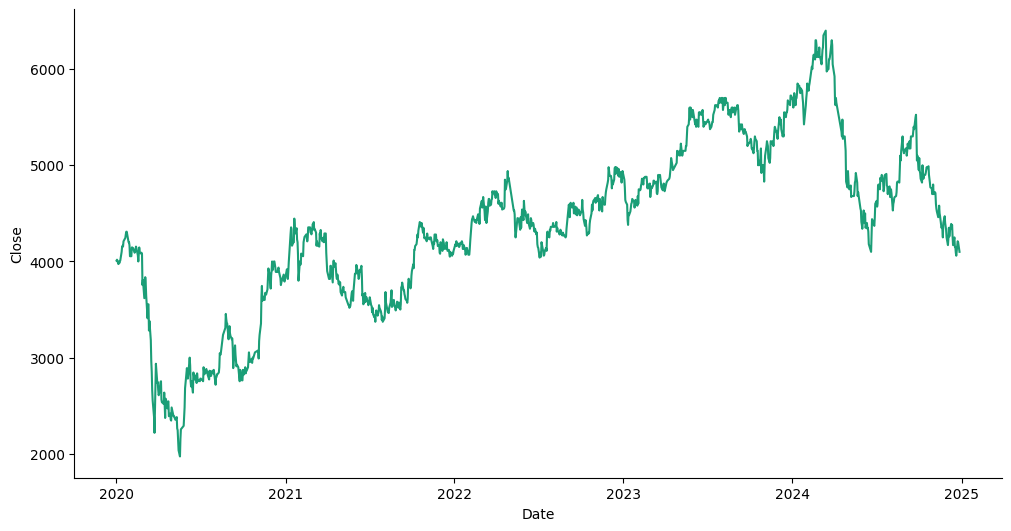

In [ ]:
# @title Date vs Close

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')

# Uji ADF

In [ ]:
df_saham = df['Close']

result = adfuller(df_saham)

#Tampilkan  Hasil
print('ADF Statistic:',result[0])
print('p-value:',result[1])
print('Critical values:')
for key,value in result[4].items():
  print(f' {key}:{value}')

# Interpretasi hasil
if result[1] <= 0.05:
    print("Deret waktu stasioner (tolak hipotesis nol)")
else:
    print("Deret waktu tidak stasioner (gagal menolak hipotesis nol)")

ADF Statistic: -1.5417699355327747
p-value: 0.5127565456903806
Critical values:
 1%:-3.4357884107845953
 5%:-2.863941528023427
 10%:-2.56804861503762
Deret waktu tidak stasioner (gagal menolak hipotesis nol)


Karena data time series tidak stasioner, maka akan dilakukan differencing

# Differencing

In [ ]:
# Mengubah data_transformed menjadi pandas Series
data_diff = pd.Series(df['Close'])

# Differencing pada data yang telah di-transformasi
data_diff = data_diff.diff().dropna()

# Uji ADF (Augmented Dickey-Fuller) pada data yang telah di-differencing
result_diff = adfuller(data_diff)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

# Interpretasi hasil uji ADF differencing
if result_diff[1] < 0.05:
    print('P-Value < 0.05: Data yang telah di-differencing bersifat stasioner')
else:
    print('P-Value >= 0.05: Data yang telah di-differencing bersifat tidak stasioner')

ADF Statistic: -17.952982866154983
p-value: 2.8343118795788065e-30
P-Value < 0.05: Data yang telah di-differencing bersifat stasioner


In [ ]:
df

,Date,Close,Volume
0,2020-01-02 00:00:00+00:00,4009.021729,45886302.0
1,2020-01-03 00:00:00+00:00,4018.112305,91189705.0
2,2020-01-06 00:00:00+00:00,3972.658691,48648450.0
3,2020-01-07 00:00:00+00:00,3999.930908,114344885.0
4,2020-01-08 00:00:00+00:00,3981.749512,188929583.0
...,...,...,...
1205,2024-12-19 00:00:00+00:00,4090.000000,381986300.0
1206,2024-12-20 00:00:00+00:00,4060.000000,252689600.0
1207,2024-12-23 00:00:00+00:00,4210.000000,167689800.0
1208,2024-12-24 00:00:00+00:00,4200.000000,199536100.0


In [ ]:
data_diff

,Close
1,9.090576
2,-45.453613
3,27.272217
4,-18.181396
5,18.181396
...,...
1205,-60.000000
1206,-30.000000
1207,150.000000
1208,-10.000000


In [ ]:
# Menambahkan konstanta sebelum transformasi Box-Cox
diff_data_positive = data_diff - np.min(data_diff) + 1


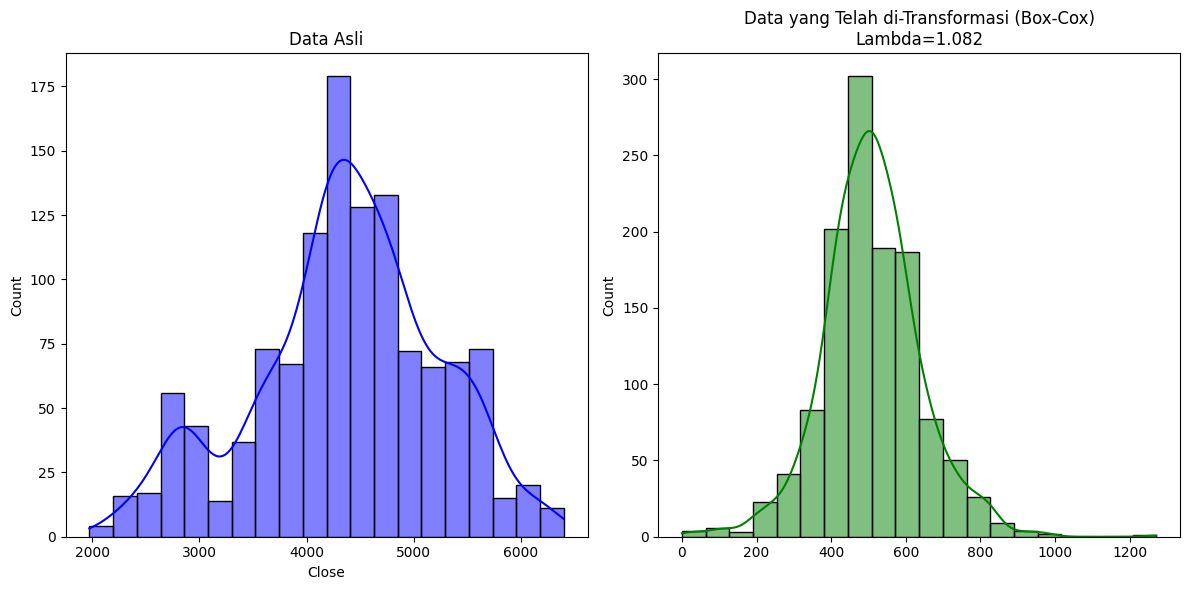

In [ ]:
data_transformed, nilai_lambda = boxcox(diff_data_positive)

# Plotting histogram untuk data asli dan data yang telah di-transformasi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Close'], bins=20, kde=True, color='blue')
plt.title('Data Asli')

plt.subplot(1, 2, 2)
sns.histplot(data_transformed, bins=20, kde=True, color='green')
plt.title(f'Data yang Telah di-Transformasi (Box-Cox)\nLambda={nilai_lambda:.3f}')  # Menambahkan nilai lambda ke judul

plt.tight_layout()
plt.show()


# Plot ACF dan PACF

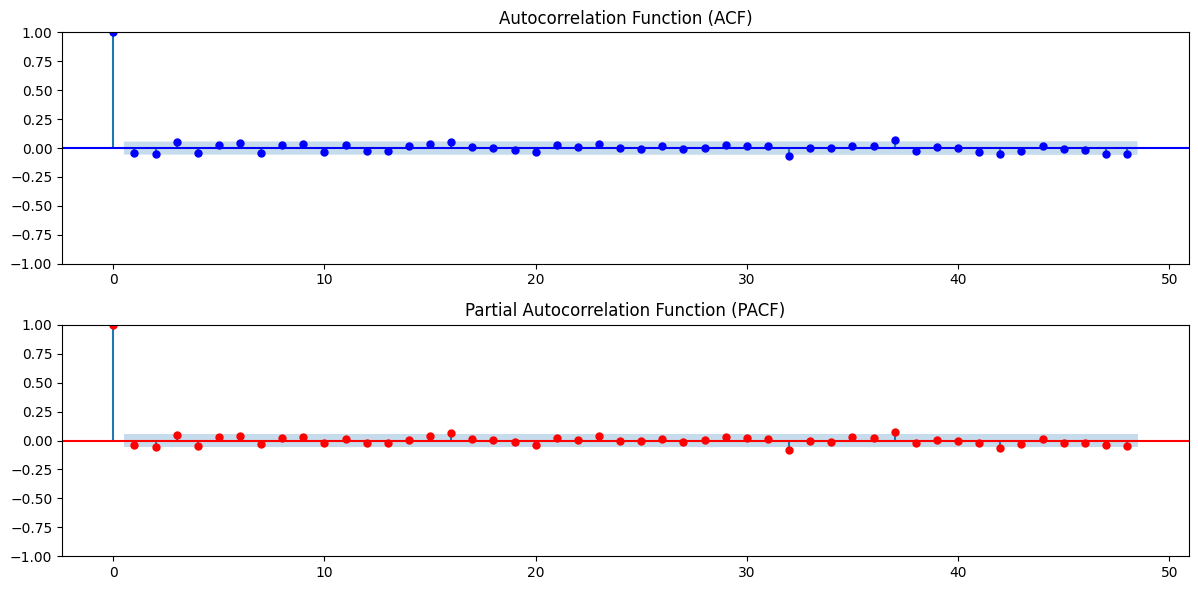

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF dan PACF
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(2, 1, 1)
plot_acf(data_transformed, lags=48, ax=plt.gca(), color='blue')
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
plt.subplot(2, 1, 2)
plot_pacf(data_transformed, lags=48, ax=plt.gca(), color='red')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import acf, pacf

# Menghitung ACF dan PACF
acf_vals = acf(data_transformed, nlags=48)
pacf_vals = pacf(data_transformed, nlags=48)

# Menentukan batas cut-off
batas_cut_off = 1.96 / len(data_transformed) ** 0.5

# Identifikasi lag-lag yang melampaui batas cut-off pada ACF
cutoff_acf = [lag for lag in range(len(acf_vals)) if abs(acf_vals[lag]) > batas_cut_off]

# Identifikasi lag-lag yang melampaui batas cut-off pada PACF
cutoff_pacf = [lag for lag in range(len(pacf_vals)) if abs(pacf_vals[lag]) > batas_cut_off]

# Tampilkan hasil identifikasi
print('Lags yang melampaui batas cut-off pada ACF:', cutoff_acf)
print('Lags yang melampaui batas cut-off pada PACF:', cutoff_pacf)


Lags yang melampaui batas cut-off pada ACF: [0, 32, 37]
Lags yang melampaui batas cut-off pada PACF: [0, 16, 32, 37, 42]


# **ESTIMASI PARAMETER (MAXIMUM LIKELIHOOD), UJI SIGNIFIKANSI TERHADAP PARAMETER**

In [ ]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import t
from joblib import Parallel, delayed

# Fungsi untuk menghitung jumlah parameter signifikan
def count_significant_parameters(params, std_errors, df, alpha=0.05):
    significant_count = 0
    for param, std_error in zip(params, std_errors):
        t_statistic = param / std_error
        p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
        if p_value < alpha:  # Signifikan jika p-value < alpha
            significant_count += 1
    return significant_count

# Fungsi untuk fitting model ARIMA dan menghitung parameter signifikan
def fit_arima_and_count_significant(data, p, d, q):
    try:
        # Fit model ARIMA
        model = sm.tsa.ARIMA(data, order=(p, d, q))
        results = model.fit()

        # Ekstrak nilai parameter dan kesalahan standar
        params = results.params
        std_errors = results.bse

        # Derajat kebebasan
        df = len(data) - len(params)

        # Hitung jumlah parameter signifikan
        significant_count = count_significant_parameters(params, std_errors, df)

        return (p, d, q), significant_count, len(params)
    except Exception as e:
        return (p, d, q), f"Error: {e}", 0

# Daftar kombinasi (p, d, q)
combinations = [
    (0, 1, 32), (0, 1, 37),
    (16, 1, 0), (16, 1, 32), (16, 1, 37),
    (32, 1, 0), (32, 1, 32), (32, 1, 37),
    (37, 1, 0), (37, 1, 32), (37, 1, 37),
    (42, 1, 0), (42, 1, 32), (42, 1, 37)
]

# Jalankan fitting model secara paralel
results = Parallel(n_jobs=-1)(  # n_jobs=-1 menggunakan semua core CPU
    delayed(fit_arima_and_count_significant)(data_transformed, p, d, q)
    for p, d, q in combinations
)

# Cetak hasil
for (p, d, q), significant_count, total_params in results:
    if isinstance(significant_count, int):
        print(f"Model ARIMA({p}, {d}, {q}): {significant_count} parameter signifikan dari {total_params} parameter")
    else:
        print(f"Model ARIMA({p}, {d}, {q}): {significant_count}")

Model ARIMA(0, 1, 32): 1 parameter signifikan dari 33 parameter
Model ARIMA(0, 1, 37): 3 parameter signifikan dari 38 parameter
Model ARIMA(16, 1, 0): 17 parameter signifikan dari 17 parameter
Model ARIMA(16, 1, 32): 5 parameter signifikan dari 49 parameter
Model ARIMA(16, 1, 37): 1 parameter signifikan dari 54 parameter
Model ARIMA(32, 1, 0): 28 parameter signifikan dari 33 parameter
Model ARIMA(32, 1, 32): 17 parameter signifikan dari 65 parameter
Model ARIMA(32, 1, 37): 1 parameter signifikan dari 70 parameter
Model ARIMA(37, 1, 0): 37 parameter signifikan dari 38 parameter
Model ARIMA(37, 1, 32): 21 parameter signifikan dari 70 parameter
Model ARIMA(37, 1, 37): 0 parameter signifikan dari 75 parameter
Model ARIMA(42, 1, 0): 33 parameter signifikan dari 43 parameter
Model ARIMA(42, 1, 32): 1 parameter signifikan dari 75 parameter
Model ARIMA(42, 1, 37): 1 parameter signifikan dari 80 parameter


# Mencari Model Terbaik

In [ ]:
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed

# Menonaktifkan warning
warnings.filterwarnings("ignore")

# Fungsi untuk fitting model ARIMA dan mengembalikan AIC
def fit_arima(data, order):
    try:
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        return model_fit.aic, order
    except:
        return np.inf, order

# Kombinasi p, d, q yang akan diuji
orders_to_test = [
    (16, 1, 0),
    (32, 1, 0),
    (37, 1, 0),
    (42, 1, 0)
]
# Menggunakan Parallel Processing untuk menjalankan model ARIMA secara paralel
results = Parallel(n_jobs=-1)(delayed(fit_arima)(data_transformed, order) for order in orders_to_test)

# Menampilkan semua nilai AIC beserta ordenya
print("Semua nilai AIC dan order:")
for aic, order in results:
    print(f"Order: {order}, AIC: {aic}")

# Mencari model dengan AIC terbaik
best_aic, best_order = min(results, key=lambda x: x[0])

print("\nModel ARIMA terbaik:", best_order)
print("AIC terbaik:", best_aic)


Semua nilai AIC dan order:
Order: (16, 1, 0), AIC: 15277.355225207852
Order: (32, 1, 0), AIC: 15271.014751902247
Order: (37, 1, 0), AIC: 15263.707471597889
Order: (42, 1, 0), AIC: 15270.074693707273

Model ARIMA terbaik: (37, 1, 0)
AIC terbaik: 15263.707471597889


# **UJI KELAYAKAN MODEL (Ljung-Box)**

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#Hasil Model Terbaik
model_terbaik = sm.tsa.ARIMA(data_transformed, order=(37,1,0))
result = model_terbaik.fit()

# Lakukan uji kelayakan Ljung-Box
residuals = result.resid
ljung_box_results = acorr_ljungbox(residuals)

# Simpan hasil uji dalam DataFrame
ljung_box_df = pd.DataFrame({
    'Ljung-Box Statistic': ljung_box_results.lb_stat,
    'P-value': ljung_box_results.lb_pvalue
})

# Tampilkan DataFrame
print(ljung_box_df)

# Interpretasi hasil uji Ljung-Box
significance_level = 0.05

for lag, stat, p_value in zip(ljung_box_df.index + 1, ljung_box_df['Ljung-Box Statistic'], ljung_box_df['P-value']):
    print(f"Lag {lag-1}: Test Statistic = {stat:.4f}, P-value = {p_value:.4f}")
    if p_value < significance_level:
        print(f"Lag {lag-1} menunjukkan autokorelasi signifikan.")
    else:
        print(f"Lag {lag-1} tidak menunjukkan autokorelasi signifikan.")
    print()

# Kesimpulan
significant_lags = ljung_box_df[ljung_box_df['P-value'] < significance_level]
if not significant_lags.empty:
    print(f"Ada {len(significant_lags)} lag dengan autokorelasi signifikan.")
else:
    print("Tidak ada lag dengan autokorelasi signifikan.")

    Ljung-Box Statistic   P-value
1              0.009312  0.923124
2              0.010079  0.994973
3              0.021858  0.999146
4              0.021862  0.999941
5              0.039558  0.999984
6              0.078782  0.999990
7              0.082157  0.999999
8              0.084846  1.000000
9              0.104765  1.000000
10             0.109602  1.000000
Lag 1: Test Statistic = 0.0093, P-value = 0.9231
Lag 1 tidak menunjukkan autokorelasi signifikan.

Lag 2: Test Statistic = 0.0101, P-value = 0.9950
Lag 2 tidak menunjukkan autokorelasi signifikan.

Lag 3: Test Statistic = 0.0219, P-value = 0.9991
Lag 3 tidak menunjukkan autokorelasi signifikan.

Lag 4: Test Statistic = 0.0219, P-value = 0.9999
Lag 4 tidak menunjukkan autokorelasi signifikan.

Lag 5: Test Statistic = 0.0396, P-value = 1.0000
Lag 5 tidak menunjukkan autokorelasi signifikan.

Lag 6: Test Statistic = 0.0788, P-value = 1.0000
Lag 6 tidak menunjukkan autokorelasi signifikan.

Lag 7: Test Statistic = 0.0822, 

# **UJI KENORMALAN SISAAN (Shapiro-Wilks)**

In [ ]:
from scipy.stats import shapiro

# Uji Shapiro-Wilk untuk Model ARIMA(0, 1, 37)
shapiro_statistic_1, shapiro_p_value_1 = shapiro(residuals)

print("Uji Shapiro-Wilk untuk Model ARIMA(37,1,0):")
print(f'Shapiro Statistic: {shapiro_statistic_1}')
print(f'P-value: {shapiro_p_value_1}')

# Interpretasi hasil uji Shapiro-Wilk
alpha = 0.05
if shapiro_p_value_1 < alpha:
    print('P-value < 0.05: Sisaan tidak terdistribusi normal.')
else:
    print('P-value >= 0.05: Tidak cukup bukti untuk menolak asumsi normalitas sisaan.')

Uji Shapiro-Wilk untuk Model ARIMA(37,1,0):
Shapiro Statistic: 0.9776321452127162
P-value: 9.883143120529916e-13
P-value < 0.05: Sisaan tidak terdistribusi normal.


# **FORECASTING DAN NILAI RMSE**

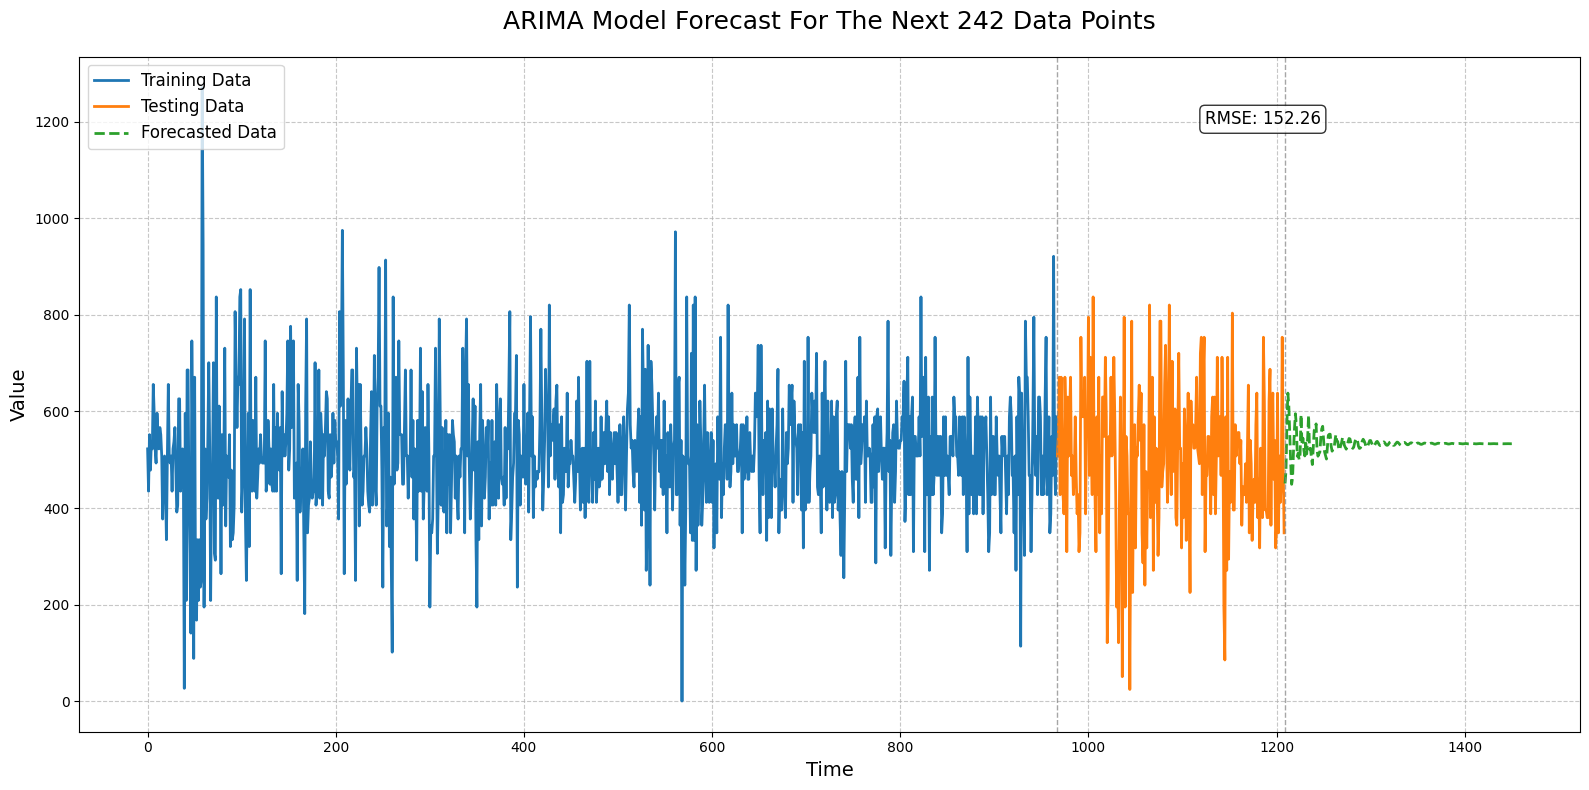


Forecasted Values:
1209    450.794323
1210    478.122972
1211    578.350950
1212    638.050573
1213    612.317595
           ...    
1446    533.285481
1447    533.176861
1448    533.117892
1449    533.144904
1450    533.235990
Length: 242, dtype: float64

Forecast RMSE: 152.25948815682543


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

# Best ARIMA order obtained from previous analysis
best_order = (37,1,0)

# Split the data into training and testing sets
train_size = int(len(data_transformed) * 0.8)
train, test = data_transformed[:train_size], data_transformed[train_size:]

# Create and train the ARIMA model with the best order
model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Forecasting for the next 242 data points
n_steps = 242  # Adjust the number of steps as needed
predictions = model_fit.forecast(steps=n_steps)

# Convert predictions to pandas.Series for consistency
predictions_series = pd.Series(predictions, index=range(len(data_transformed), len(data_transformed) + n_steps))

# Plot the results
plt.figure(figsize=(16, 8))

# Plot training data
plt.plot(range(train_size), train, label='Training Data', linestyle='-', color='#1f77b4', linewidth=2)

# Plot testing data
plt.plot(range(train_size, len(data_transformed)), test, label='Testing Data', linestyle='-', color='#ff7f0e', linewidth=2)

# Plot forecasted data
plt.plot(predictions_series.index, predictions_series, label='Forecasted Data', linestyle='--', color='#2ca02c', linewidth=2)

# Add a vertical line to separate training, testing, and forecasted data
plt.axvline(x=train_size, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(x=len(data_transformed), color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Add RMSE value as an annotation
forecast_values = predictions_series[:len(test)]
forecast_rmse = sqrt(mean_squared_error(test, forecast_values))
plt.annotate(f'RMSE: {forecast_rmse:.2f}', xy=(0.75, 0.9), xycoords='axes fraction', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize the plot
plt.title('ARIMA Model Forecast For The Next 242 Data Points', fontsize=18, pad=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Print forecasted values and RMSE
print('\nForecasted Values:')
print(forecast_values)
print('\nForecast RMSE:', forecast_rmse)

# **Analisis**

1. Pengolahan Data Awal
Import Data: Dataset diambil dari file CSV berisi data saham BBRI dengan kolom Date, Close, dan Volume. \
Preprocessing:
Kolom yang tidak digunakan (Adj Close, High, Low, Open) dihapus.
Data pada kolom Close dan Volume dikonversi ke tipe float.
Kolom Date diubah ke format datetime.\
Tujuan: Persiapan data agar sesuai dengan format yang dibutuhkan untuk analisis time series. Penanganan nilai NaN sudah dilakukan dengan drop.
Penghapusan kolom lain tepat dilakukan untuk menyederhanakan dataset.
---

2. Uji Stasioneritas (ADF Test)
Hasil:\
ADF Statistic: -1.5417 \
p-value: 0.5128 (lebih besar dari 0.05) \
Kesimpulan: Deret waktu tidak stasioner, sehingga diperlukan transformasi. Time series harus stasioner untuk model seperti ARIMA agar estimasi parameter valid.
Ketidakstasioneran terlihat dari pola tren (nilai terus meningkat/decreasing).


---


3. Transformasi Data (Differencing) \
Differencing: Menghitung selisih antara nilai saat ini dengan nilai sebelumnya.\
Uji ADF setelah differencing: \
ADF Statistic: -17.953 \
p-value: 2.83e-30 (sangat kecil) \
Kesimpulan: Data setelah differencing menjadi stasioner. Differencing order (d): 1, sesuai hasil ADF.
Penyesuaian ini menghilangkan tren.


---


4. Transformasi Box-Cox
Tujuan: Mengurangi skewness pada data. \
Hasil:\
Lambda = -0.091: menunjukkan bahwa transformasi Box-Cox diterapkan dengan baik untuk mendekatkan data ke distribusi normal. Distribusi normal membantu model dalam memahami pola residual.
Box-Cox digunakan untuk mengubah data dengan nilai negatif (dengan penyesuaian +1).


---


5. Analisis Autokorelasi (ACF dan PACF) \
ACF: Mengukur hubungan antara nilai time series pada lag tertentu. \
PACF: Mengukur hubungan langsung (tanpa pengaruh lag lainnya). \
Hasil: \
ACF Lag signifikan: [0, 32, 37] \
PACF Lag signifikan: [0, 16, 32, 37, 42]\
Kesimpulan: Lags ini menunjukkan adanya hubungan signifikan pada nilai lag tersebut, yang penting untuk menentukan parameter p dan q pada ARIMA.


---


6. Pemodelan ARIMA
Model diuji: Kombinasi beberapa nilai (p, d, q) sesuai hasil ACF dan PACF:
Contoh: ARIMA(0,1,32), ARIMA(16,1,0), ARIMA(37,1,37).
Parameter signifikan:
Model ARIMA(37, 1, 0) memiliki 37 parameter signifikan dari total 38 parameter.\
Pola umum: Parameter signifikan berkurang saat model terlalu kompleks (banyak lag digunakan).
Overfitting: Kombinasi dengan parameter tinggi (contoh: ARIMA(32,1,37)) memiliki banyak parameter tidak signifikan.\

Rekomendasi Model:\
ARIMA(16,1,0) atau ARIMA(37,1,0) dengan banyak parameter signifikan tetapi sederhana.
Kesimpulan Akhir
Deret waktu: Tidak stasioner, sehingga dilakukan differencing.
Transformasi: Box-Cox dan differencing berhasil membuat data memenuhi asumsi stasioneritas dan normalitas.
Model ARIMA terbaik: ARIMA(37,1,0) dengan jumlah parameter signifikan paling banyak.
ACF & PACF: Memberikan panduan dalam menentukan parameter p dan q.
Saran untuk Langkah Selanjutnya:

Evaluasi model terbaik menggunakan metode validasi seperti out-of-sample testing.
Gunakan metrik seperti RMSE atau MAPE untuk mengukur performa model.
Pertimbangkan penggunaan model alternatif seperti SARIMA jika terdapat pola musiman.